In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Class names
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
## 基础的CNN

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # [3, 32, 32] -> [32, 32, 32]
        self.pool = nn.MaxPool2d(2, 2)              # -> [32, 16, 16]
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # -> [64, 16, 16] -> [64, 8, 8]
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = x.view(-1, 64 * 8 * 8)            # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train(model, optimizer, criterion, epochs=10):
    model.train()
    train_loss_list = []
    train_acc_list = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total

        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return train_loss_list, train_acc_list

def test(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

def plot_training_curves(loss_list, acc_list):
    epochs = range(1, len(loss_list) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_list, label='Training Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Curve')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Using device: cuda


Epoch 1/30, Loss: 1.2884, Accuracy: 53.84%
Epoch 2/30, Loss: 0.8944, Accuracy: 68.63%
Epoch 3/30, Loss: 0.7085, Accuracy: 75.15%
Epoch 4/30, Loss: 0.5513, Accuracy: 80.73%
Epoch 5/30, Loss: 0.3955, Accuracy: 86.35%
Epoch 6/30, Loss: 0.2596, Accuracy: 91.31%
Epoch 7/30, Loss: 0.1587, Accuracy: 94.74%
Epoch 8/30, Loss: 0.1047, Accuracy: 96.56%
Epoch 9/30, Loss: 0.0762, Accuracy: 97.51%
Epoch 10/30, Loss: 0.0676, Accuracy: 97.70%
Epoch 11/30, Loss: 0.0637, Accuracy: 97.84%
Epoch 12/30, Loss: 0.0620, Accuracy: 97.93%
Epoch 13/30, Loss: 0.0460, Accuracy: 98.41%
Epoch 14/30, Loss: 0.0463, Accuracy: 98.48%
Epoch 15/30, Loss: 0.0441, Accuracy: 98.45%
Epoch 16/30, Loss: 0.0464, Accuracy: 98.44%
Epoch 17/30, Loss: 0.0413, Accuracy: 98.58%
Epoch 18/30, Loss: 0.0401, Accuracy: 98.66%
Epoch 19/30, Loss: 0.0427, Accuracy: 98.65%
Epoch 20/30, Loss: 0.0371, Accuracy: 98.75%
Epoch 21/30, Loss: 0.0301, Accuracy: 98.96%
Epoch 22/30, Loss: 0.0326, Accuracy: 98.92%
Epoch 23/30, Loss: 0.0375, Accuracy: 98.8

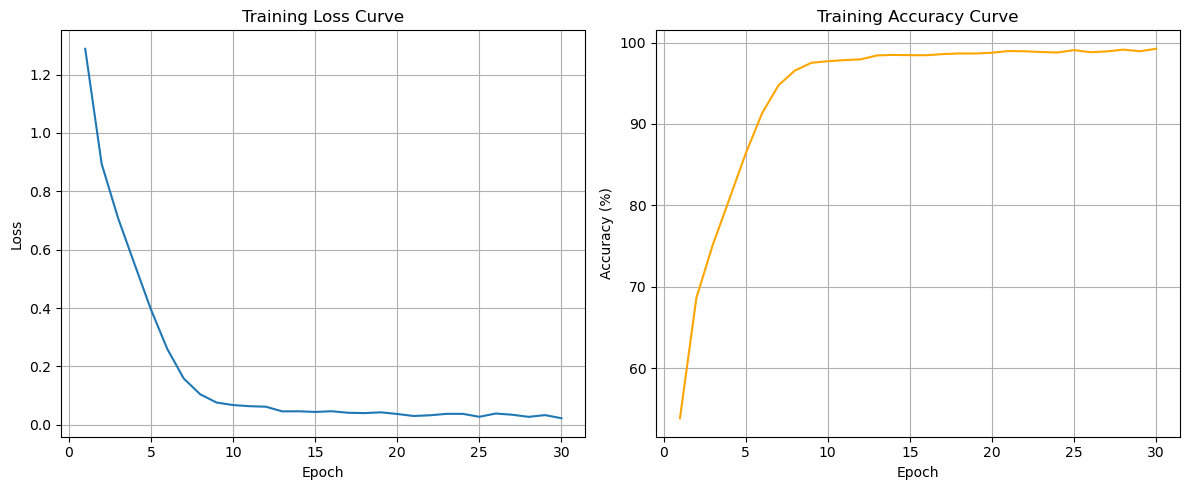

Test Accuracy: 71.48%


In [7]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

## 加入dropout、BN和残差连接的CNN

In [11]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # 残差连接
        self.res_conv = nn.Conv2d(32, 64, kernel_size=1)
        self.res_bn = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout + 全连接层
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B, 32, 16, 16]
        residual = x                                    # for skip connection
        out = F.relu(self.bn2(self.conv2(x)))           # [B, 64, 16, 16]
        out = self.pool(out)                            # [B, 64, 8, 8]

        # 残差连接：把 residual 也变成 [B, 64, 8, 8] 再相加
        residual = self.pool(self.res_bn(self.res_conv(residual)))  # projection shortcut
        x = out + residual                               # Add residual connection

        x = x.view(-1, 64 * 8 * 8)                       # Flatten
        x = F.relu(self.dropout(self.fc1(x)))            # Dropout
        x = self.fc2(x)
        return x


Epoch 1/20, Loss: 1.5450, Accuracy: 44.70%
Epoch 2/20, Loss: 1.2012, Accuracy: 57.19%
Epoch 3/20, Loss: 1.0523, Accuracy: 62.86%
Epoch 4/20, Loss: 0.9601, Accuracy: 66.30%
Epoch 5/20, Loss: 0.8896, Accuracy: 68.99%
Epoch 6/20, Loss: 0.8256, Accuracy: 70.86%
Epoch 7/20, Loss: 0.7652, Accuracy: 73.25%
Epoch 8/20, Loss: 0.7126, Accuracy: 74.78%
Epoch 9/20, Loss: 0.6482, Accuracy: 77.11%
Epoch 10/20, Loss: 0.5931, Accuracy: 79.00%
Epoch 11/20, Loss: 0.5383, Accuracy: 80.94%
Epoch 12/20, Loss: 0.4873, Accuracy: 82.60%
Epoch 13/20, Loss: 0.4349, Accuracy: 84.48%
Epoch 14/20, Loss: 0.3910, Accuracy: 86.02%
Epoch 15/20, Loss: 0.3554, Accuracy: 87.36%
Epoch 16/20, Loss: 0.3157, Accuracy: 88.77%
Epoch 17/20, Loss: 0.2885, Accuracy: 89.86%
Epoch 18/20, Loss: 0.2662, Accuracy: 90.70%
Epoch 19/20, Loss: 0.2395, Accuracy: 91.60%
Epoch 20/20, Loss: 0.2297, Accuracy: 91.96%


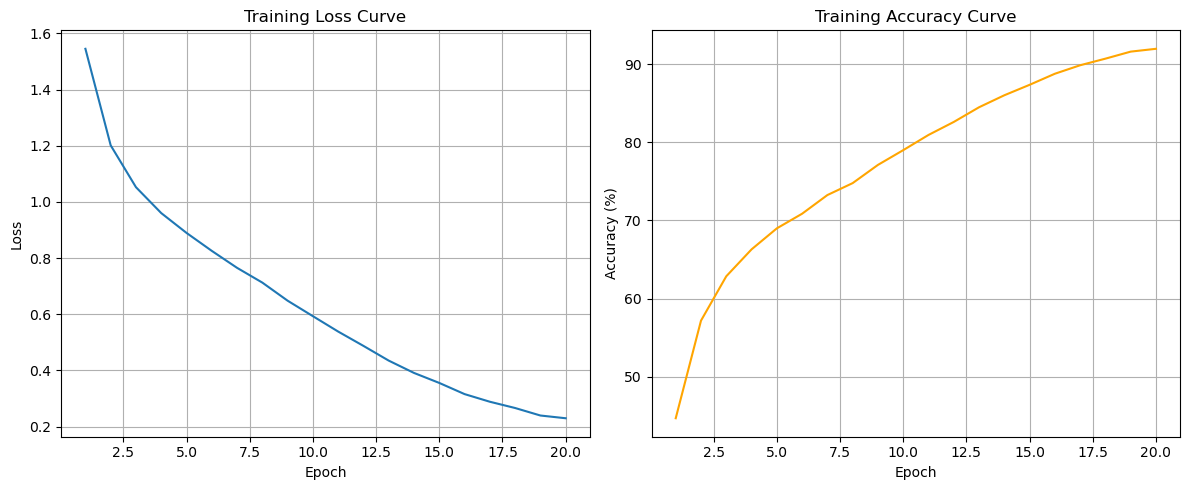

Test Accuracy: 75.07%


In [12]:
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=20)
plot_training_curves(train_losses, train_accuracies)
test(model)


## 更深的CNN

In [13]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 8 -> 4
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.classifier(x)
        return x


Epoch 1/30, Loss: 1.4518, Accuracy: 47.06%
Epoch 2/30, Loss: 1.0199, Accuracy: 64.12%
Epoch 3/30, Loss: 0.8480, Accuracy: 70.69%
Epoch 4/30, Loss: 0.7274, Accuracy: 75.21%
Epoch 5/30, Loss: 0.6325, Accuracy: 78.57%
Epoch 6/30, Loss: 0.5559, Accuracy: 81.30%
Epoch 7/30, Loss: 0.4936, Accuracy: 83.19%
Epoch 8/30, Loss: 0.4227, Accuracy: 85.60%
Epoch 9/30, Loss: 0.3653, Accuracy: 87.44%
Epoch 10/30, Loss: 0.3182, Accuracy: 89.15%
Epoch 11/30, Loss: 0.2773, Accuracy: 90.53%
Epoch 12/30, Loss: 0.2381, Accuracy: 91.79%
Epoch 13/30, Loss: 0.2073, Accuracy: 92.90%
Epoch 14/30, Loss: 0.1813, Accuracy: 93.81%
Epoch 15/30, Loss: 0.1608, Accuracy: 94.49%
Epoch 16/30, Loss: 0.1378, Accuracy: 95.26%
Epoch 17/30, Loss: 0.1248, Accuracy: 95.65%
Epoch 18/30, Loss: 0.1155, Accuracy: 96.00%
Epoch 19/30, Loss: 0.1078, Accuracy: 96.33%
Epoch 20/30, Loss: 0.0967, Accuracy: 96.73%
Epoch 21/30, Loss: 0.0931, Accuracy: 96.79%
Epoch 22/30, Loss: 0.0819, Accuracy: 97.28%
Epoch 23/30, Loss: 0.0768, Accuracy: 97.4

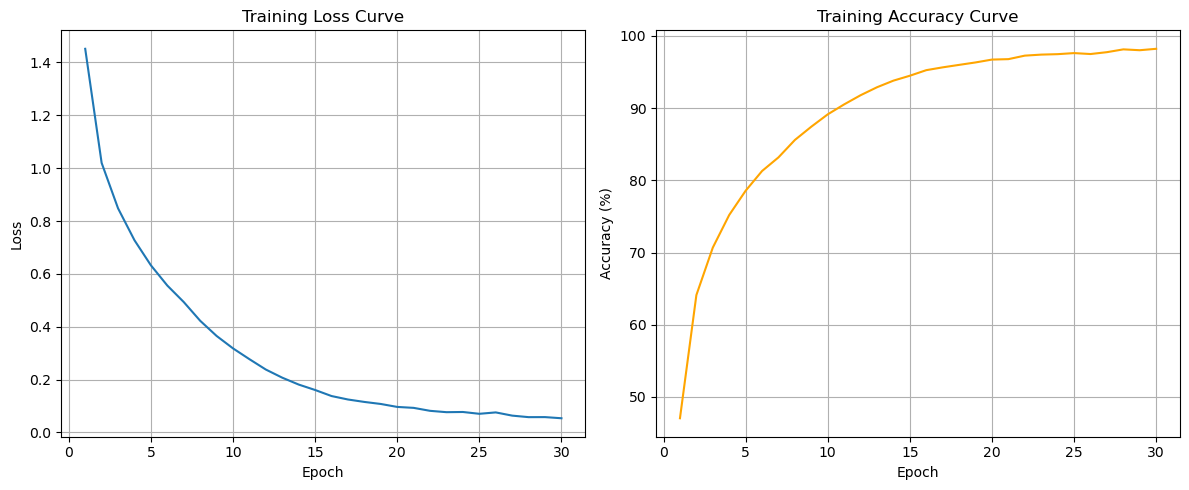

Test Accuracy: 84.73%


In [14]:
model = DeepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

## Resnet

In [17]:
import os

save_dir = r'D:\NN_DL\PJ2\codes\saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'model_1.pth')

torch.save(model.state_dict(), save_path)


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # 残差连接
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Stack Residual Blocks
        self.layer1 = self._make_layer(64, 128, stride=2)  # 32 -> 16
        self.layer2 = self._make_layer(128, 256, stride=2) # 16 -> 8
        self.layer3 = self._make_layer(256, 256, stride=2) # 8 -> 4

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))        # [256, 1, 1]
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def _make_layer(self, in_ch, out_ch, stride):
        return nn.Sequential(
            ResidualBlock(in_ch, out_ch, stride),
            ResidualBlock(out_ch, out_ch)
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


Epoch 1/30, Loss: 1.2672, Accuracy: 54.02%
Epoch 2/30, Loss: 0.7917, Accuracy: 71.93%
Epoch 3/30, Loss: 0.5964, Accuracy: 79.12%
Epoch 4/30, Loss: 0.4645, Accuracy: 83.81%
Epoch 5/30, Loss: 0.3558, Accuracy: 87.54%
Epoch 6/30, Loss: 0.2628, Accuracy: 90.69%
Epoch 7/30, Loss: 0.1860, Accuracy: 93.50%
Epoch 8/30, Loss: 0.1385, Accuracy: 95.17%
Epoch 9/30, Loss: 0.1059, Accuracy: 96.24%
Epoch 10/30, Loss: 0.0817, Accuracy: 97.09%
Epoch 11/30, Loss: 0.0664, Accuracy: 97.64%
Epoch 12/30, Loss: 0.0616, Accuracy: 97.91%
Epoch 13/30, Loss: 0.0549, Accuracy: 98.11%
Epoch 14/30, Loss: 0.0474, Accuracy: 98.31%
Epoch 15/30, Loss: 0.0417, Accuracy: 98.50%
Epoch 16/30, Loss: 0.0447, Accuracy: 98.42%
Epoch 17/30, Loss: 0.0417, Accuracy: 98.56%
Epoch 18/30, Loss: 0.0315, Accuracy: 98.95%
Epoch 19/30, Loss: 0.0384, Accuracy: 98.72%
Epoch 20/30, Loss: 0.0361, Accuracy: 98.72%
Epoch 21/30, Loss: 0.0267, Accuracy: 99.03%
Epoch 22/30, Loss: 0.0336, Accuracy: 98.89%
Epoch 23/30, Loss: 0.0244, Accuracy: 99.1

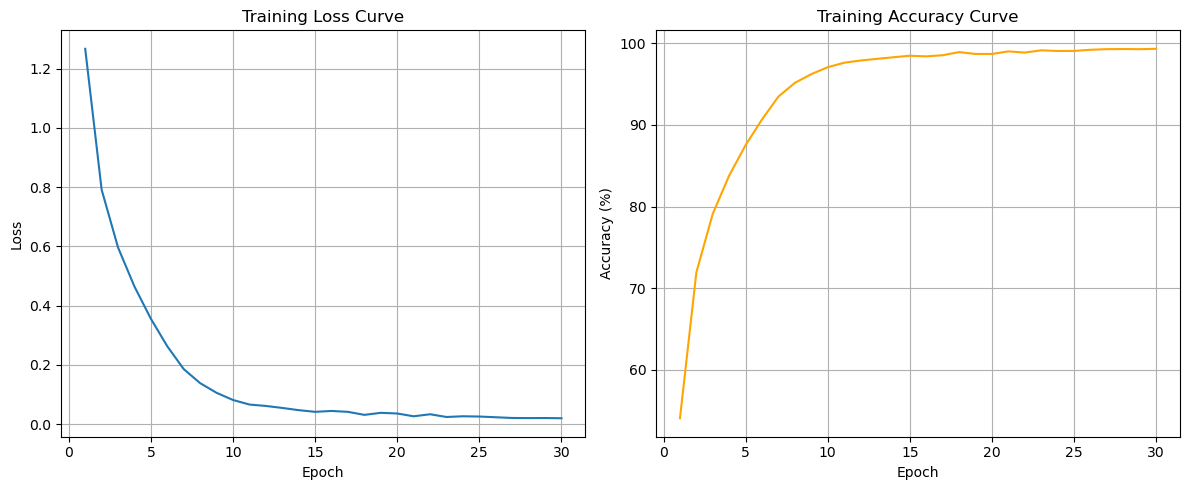

Test Accuracy: 83.23%


In [19]:
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)


In [20]:
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'model_2.pth')

torch.save(model.state_dict(), save_path)

## 带数据增强的Resnet

In [5]:
import torchvision.transforms as transforms

# 数据增强
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # 随机裁剪（带填充）
    transforms.RandomHorizontalFlip(),         # 水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 色彩扰动
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 测试集不变
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


Epoch 1/30, Loss: 1.5535, Accuracy: 42.75%
Epoch 2/30, Loss: 1.0786, Accuracy: 61.77%
Epoch 3/30, Loss: 0.8853, Accuracy: 69.48%
Epoch 4/30, Loss: 0.7611, Accuracy: 74.11%
Epoch 5/30, Loss: 0.6821, Accuracy: 76.83%
Epoch 6/30, Loss: 0.6208, Accuracy: 79.01%
Epoch 7/30, Loss: 0.5689, Accuracy: 80.87%
Epoch 8/30, Loss: 0.5317, Accuracy: 82.10%
Epoch 9/30, Loss: 0.4993, Accuracy: 83.29%
Epoch 10/30, Loss: 0.4722, Accuracy: 84.29%
Epoch 11/30, Loss: 0.4489, Accuracy: 84.94%
Epoch 12/30, Loss: 0.4236, Accuracy: 85.76%
Epoch 13/30, Loss: 0.4014, Accuracy: 86.60%
Epoch 14/30, Loss: 0.3925, Accuracy: 86.81%
Epoch 15/30, Loss: 0.3759, Accuracy: 87.31%
Epoch 16/30, Loss: 0.3621, Accuracy: 88.00%
Epoch 17/30, Loss: 0.3542, Accuracy: 88.15%
Epoch 18/30, Loss: 0.3363, Accuracy: 88.55%
Epoch 19/30, Loss: 0.3283, Accuracy: 89.01%
Epoch 20/30, Loss: 0.3141, Accuracy: 89.36%
Epoch 21/30, Loss: 0.3084, Accuracy: 89.56%
Epoch 22/30, Loss: 0.3034, Accuracy: 89.74%
Epoch 23/30, Loss: 0.2977, Accuracy: 89.9

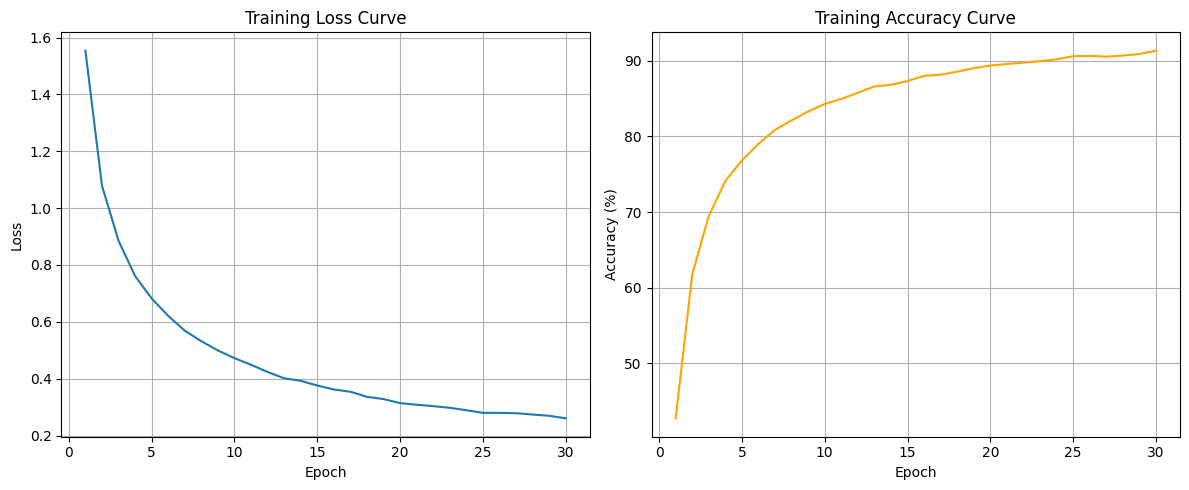

Test Accuracy: 89.11%


In [18]:
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [19]:
torch.save(model.state_dict(), "model_res_rein.pth")

In [12]:

class DeepCNN_Res(nn.Module):
    def __init__(self, activation_fn=nn.ReLU):
        super(DeepCNN_Res, self).__init__()
        self.act = activation_fn()

        # Block 1
        self.conv1a = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(64)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(64)
        self.res1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.BatchNorm2d(64)
        )
        self.pool1 = nn.MaxPool2d(2)

        # Block 2
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(128)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(128)
        self.res2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),
            nn.BatchNorm2d(128)
        )
        self.pool2 = nn.MaxPool2d(2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2)

        # Classifier
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Block 1 with residual
        identity1 = self.res1(x)
        x = self.act(self.bn1a(self.conv1a(x)))
        x = self.act(self.bn1b(self.conv1b(x)))
        x = x + identity1
        x = self.pool1(x)

        # Block 2 with residual
        identity2 = self.res2(x)
        x = self.act(self.bn2a(self.conv2a(x)))
        x = self.act(self.bn2b(self.conv2b(x)))
        x = x + identity2
        x = self.pool2(x)

        # Block 3
        x = self.act(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        # Classifier
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x


Epoch 1/30, Loss: 1.6911, Accuracy: 37.40%
Epoch 2/30, Loss: 1.2882, Accuracy: 53.23%
Epoch 3/30, Loss: 1.1116, Accuracy: 60.62%
Epoch 4/30, Loss: 0.9880, Accuracy: 65.33%
Epoch 5/30, Loss: 0.9084, Accuracy: 68.69%
Epoch 6/30, Loss: 0.8355, Accuracy: 71.50%
Epoch 7/30, Loss: 0.7777, Accuracy: 73.35%
Epoch 8/30, Loss: 0.7257, Accuracy: 75.37%
Epoch 9/30, Loss: 0.6792, Accuracy: 77.06%
Epoch 10/30, Loss: 0.6343, Accuracy: 78.71%
Epoch 11/30, Loss: 0.5909, Accuracy: 80.24%
Epoch 12/30, Loss: 0.5534, Accuracy: 81.41%
Epoch 13/30, Loss: 0.5180, Accuracy: 82.70%
Epoch 14/30, Loss: 0.4956, Accuracy: 83.47%
Epoch 15/30, Loss: 0.4636, Accuracy: 84.49%
Epoch 16/30, Loss: 0.4410, Accuracy: 85.34%
Epoch 17/30, Loss: 0.4251, Accuracy: 85.77%
Epoch 18/30, Loss: 0.4099, Accuracy: 86.29%
Epoch 19/30, Loss: 0.3870, Accuracy: 86.95%
Epoch 20/30, Loss: 0.3792, Accuracy: 87.28%
Epoch 21/30, Loss: 0.3581, Accuracy: 87.97%
Epoch 22/30, Loss: 0.3457, Accuracy: 88.21%
Epoch 23/30, Loss: 0.3421, Accuracy: 88.5

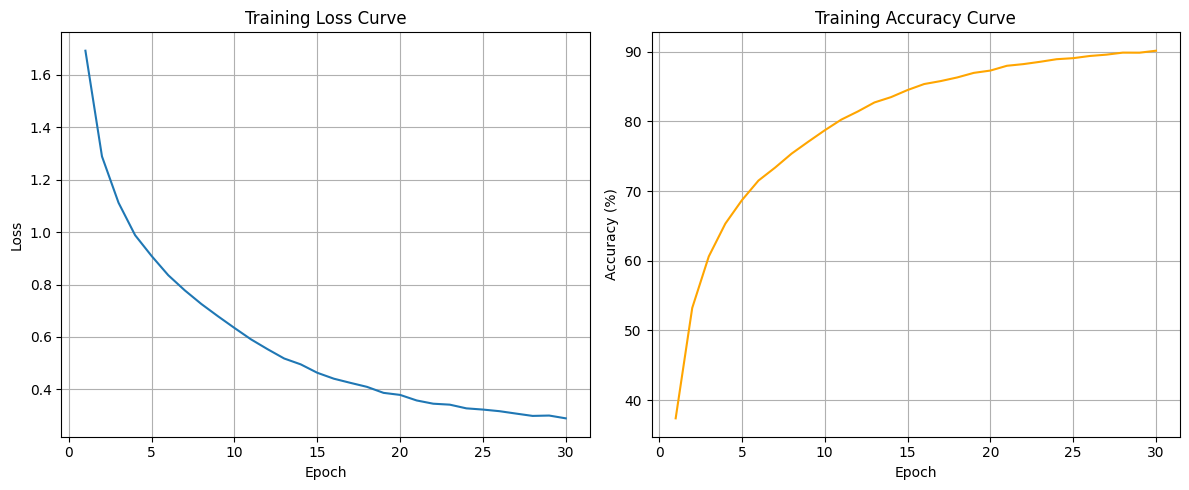

Test Accuracy: 88.89%


In [27]:
model = DeepCNN_Res(activation_fn=nn.ReLU).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [28]:
torch.save(model.state_dict(), "model_cnn_res_relu.pth")

Epoch 1/30, Loss: 1.5700, Accuracy: 42.67%
Epoch 2/30, Loss: 1.1656, Accuracy: 58.33%
Epoch 3/30, Loss: 0.9860, Accuracy: 65.41%
Epoch 4/30, Loss: 0.8699, Accuracy: 69.66%
Epoch 5/30, Loss: 0.7732, Accuracy: 73.24%
Epoch 6/30, Loss: 0.6977, Accuracy: 76.09%
Epoch 7/30, Loss: 0.6316, Accuracy: 78.39%
Epoch 8/30, Loss: 0.5842, Accuracy: 80.08%
Epoch 9/30, Loss: 0.5359, Accuracy: 81.77%
Epoch 10/30, Loss: 0.4979, Accuracy: 83.03%
Epoch 11/30, Loss: 0.4679, Accuracy: 84.17%
Epoch 12/30, Loss: 0.4441, Accuracy: 85.00%
Epoch 13/30, Loss: 0.4195, Accuracy: 85.74%
Epoch 14/30, Loss: 0.4014, Accuracy: 86.43%
Epoch 15/30, Loss: 0.3891, Accuracy: 86.74%
Epoch 16/30, Loss: 0.3772, Accuracy: 87.24%
Epoch 17/30, Loss: 0.3581, Accuracy: 87.97%
Epoch 18/30, Loss: 0.3467, Accuracy: 88.27%
Epoch 19/30, Loss: 0.3436, Accuracy: 88.29%
Epoch 20/30, Loss: 0.3313, Accuracy: 88.69%
Epoch 21/30, Loss: 0.3262, Accuracy: 88.99%
Epoch 22/30, Loss: 0.3146, Accuracy: 89.37%
Epoch 23/30, Loss: 0.3034, Accuracy: 89.5

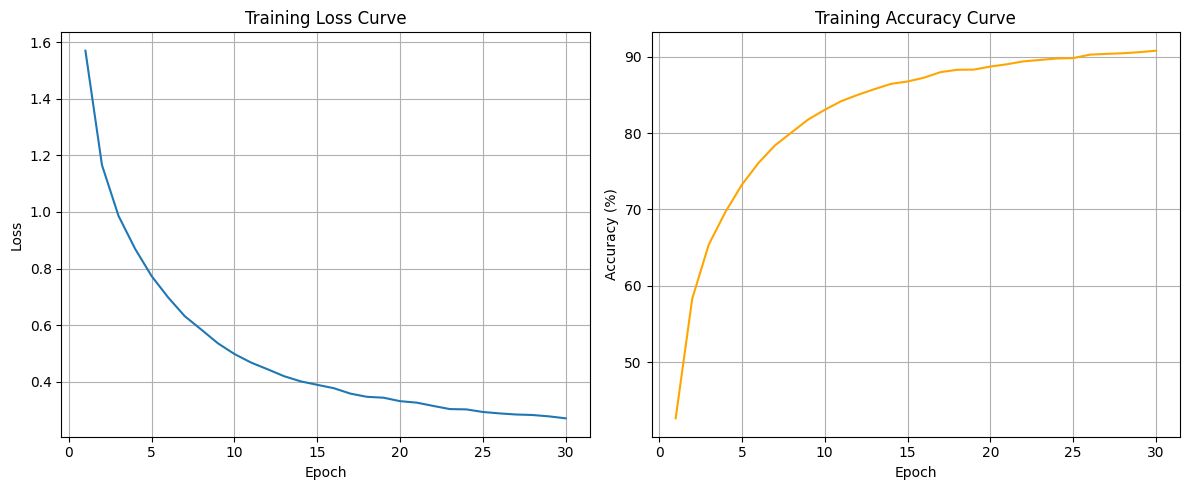

Test Accuracy: 88.88%


In [8]:
model = DeepCNN_Res(activation_fn=nn.GELU).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [9]:
torch.save(model.state_dict(), "model_cnn_res_gelu.pth")

Epoch 1/30, Loss: 1.6868, Accuracy: 37.99%
Epoch 2/30, Loss: 1.2668, Accuracy: 54.53%
Epoch 3/30, Loss: 1.0713, Accuracy: 61.97%
Epoch 4/30, Loss: 0.9409, Accuracy: 66.88%
Epoch 5/30, Loss: 0.8434, Accuracy: 70.64%
Epoch 6/30, Loss: 0.7667, Accuracy: 73.30%
Epoch 7/30, Loss: 0.7010, Accuracy: 75.88%
Epoch 8/30, Loss: 0.6356, Accuracy: 78.28%
Epoch 9/30, Loss: 0.5934, Accuracy: 79.62%
Epoch 10/30, Loss: 0.5472, Accuracy: 81.42%
Epoch 11/30, Loss: 0.5069, Accuracy: 82.77%
Epoch 12/30, Loss: 0.4769, Accuracy: 83.81%
Epoch 13/30, Loss: 0.4539, Accuracy: 84.73%
Epoch 14/30, Loss: 0.4270, Accuracy: 85.49%
Epoch 15/30, Loss: 0.4168, Accuracy: 85.77%
Epoch 16/30, Loss: 0.3960, Accuracy: 86.61%
Epoch 17/30, Loss: 0.3778, Accuracy: 87.15%
Epoch 18/30, Loss: 0.3676, Accuracy: 87.47%
Epoch 19/30, Loss: 0.3516, Accuracy: 88.12%
Epoch 20/30, Loss: 0.3459, Accuracy: 88.12%
Epoch 21/30, Loss: 0.3337, Accuracy: 88.61%
Epoch 22/30, Loss: 0.3279, Accuracy: 88.87%
Epoch 23/30, Loss: 0.3172, Accuracy: 89.1

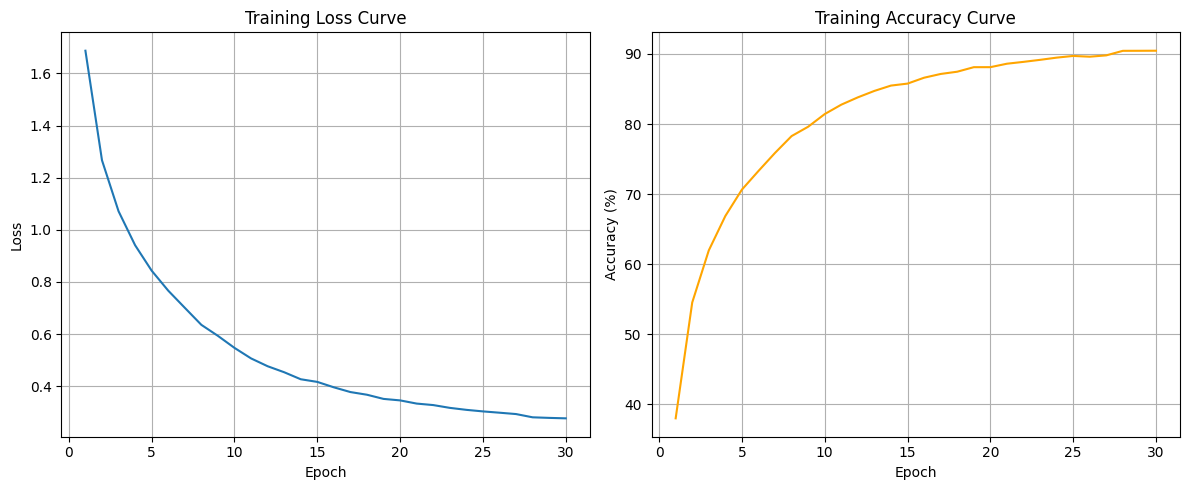

Test Accuracy: 87.90%


In [10]:
model = DeepCNN_Res(activation_fn=nn.LeakyReLU).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [11]:
torch.save(model.state_dict(), "model_cnn_res_leakyrelu.pth")

Epoch 1/30, Loss: 1.7037, Accuracy: 43.76%
Epoch 2/30, Loss: 1.3490, Accuracy: 61.74%
Epoch 3/30, Loss: 1.2111, Accuracy: 69.19%
Epoch 4/30, Loss: 1.1083, Accuracy: 74.16%
Epoch 5/30, Loss: 1.0513, Accuracy: 76.76%
Epoch 6/30, Loss: 1.0061, Accuracy: 78.93%
Epoch 7/30, Loss: 0.9686, Accuracy: 80.68%
Epoch 8/30, Loss: 0.9354, Accuracy: 82.00%
Epoch 9/30, Loss: 0.9121, Accuracy: 83.12%
Epoch 10/30, Loss: 0.8855, Accuracy: 84.28%
Epoch 11/30, Loss: 0.8717, Accuracy: 85.06%
Epoch 12/30, Loss: 0.8532, Accuracy: 85.86%
Epoch 13/30, Loss: 0.8345, Accuracy: 86.63%
Epoch 14/30, Loss: 0.8292, Accuracy: 86.62%
Epoch 15/30, Loss: 0.8193, Accuracy: 87.16%
Epoch 16/30, Loss: 0.8083, Accuracy: 87.63%
Epoch 17/30, Loss: 0.7997, Accuracy: 88.12%
Epoch 18/30, Loss: 0.7929, Accuracy: 88.34%
Epoch 19/30, Loss: 0.7841, Accuracy: 88.73%
Epoch 20/30, Loss: 0.7782, Accuracy: 88.96%
Epoch 21/30, Loss: 0.7735, Accuracy: 89.20%
Epoch 22/30, Loss: 0.7693, Accuracy: 89.35%
Epoch 23/30, Loss: 0.7634, Accuracy: 89.6

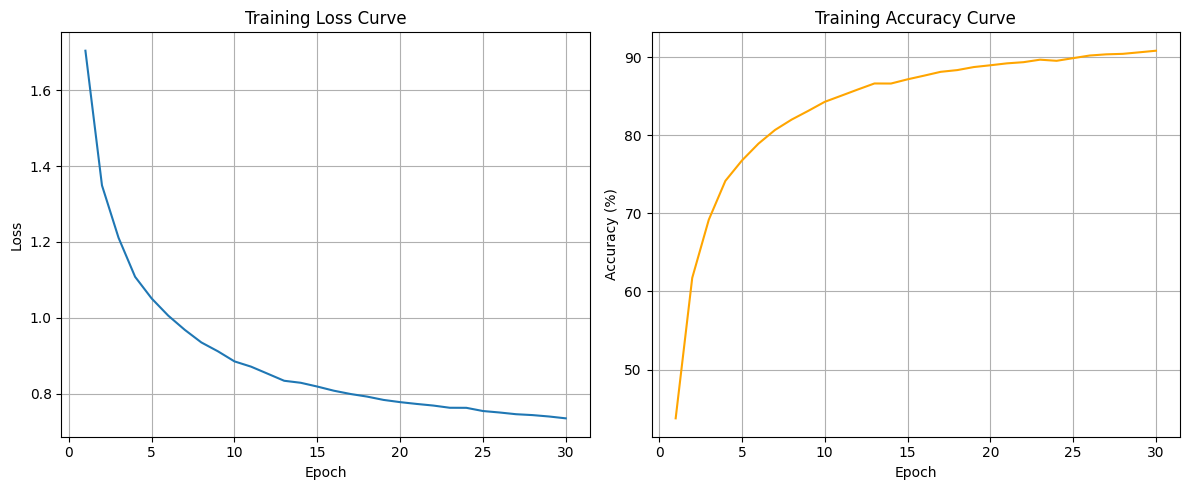

Test Accuracy: 88.69%


In [14]:
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [15]:
torch.save(model.state_dict(), "model_res_lblsmt.pth")

Epoch 1/30, Loss: 1.5030, Accuracy: 44.96%
Epoch 2/30, Loss: 1.0368, Accuracy: 63.09%
Epoch 3/30, Loss: 0.8237, Accuracy: 71.36%
Epoch 4/30, Loss: 0.6900, Accuracy: 76.24%
Epoch 5/30, Loss: 0.6035, Accuracy: 79.50%
Epoch 6/30, Loss: 0.5491, Accuracy: 81.23%
Epoch 7/30, Loss: 0.4967, Accuracy: 83.27%
Epoch 8/30, Loss: 0.4570, Accuracy: 84.53%
Epoch 9/30, Loss: 0.4179, Accuracy: 85.89%
Epoch 10/30, Loss: 0.3859, Accuracy: 86.97%
Epoch 11/30, Loss: 0.3581, Accuracy: 87.79%
Epoch 12/30, Loss: 0.3338, Accuracy: 88.65%
Epoch 13/30, Loss: 0.3132, Accuracy: 89.43%
Epoch 14/30, Loss: 0.2886, Accuracy: 90.12%
Epoch 15/30, Loss: 0.2705, Accuracy: 90.72%
Epoch 16/30, Loss: 0.2568, Accuracy: 91.31%
Epoch 17/30, Loss: 0.2324, Accuracy: 92.01%
Epoch 18/30, Loss: 0.2251, Accuracy: 92.34%
Epoch 19/30, Loss: 0.2122, Accuracy: 92.71%
Epoch 20/30, Loss: 0.1963, Accuracy: 93.23%
Epoch 21/30, Loss: 0.1871, Accuracy: 93.57%
Epoch 22/30, Loss: 0.1776, Accuracy: 93.95%
Epoch 23/30, Loss: 0.1638, Accuracy: 94.3

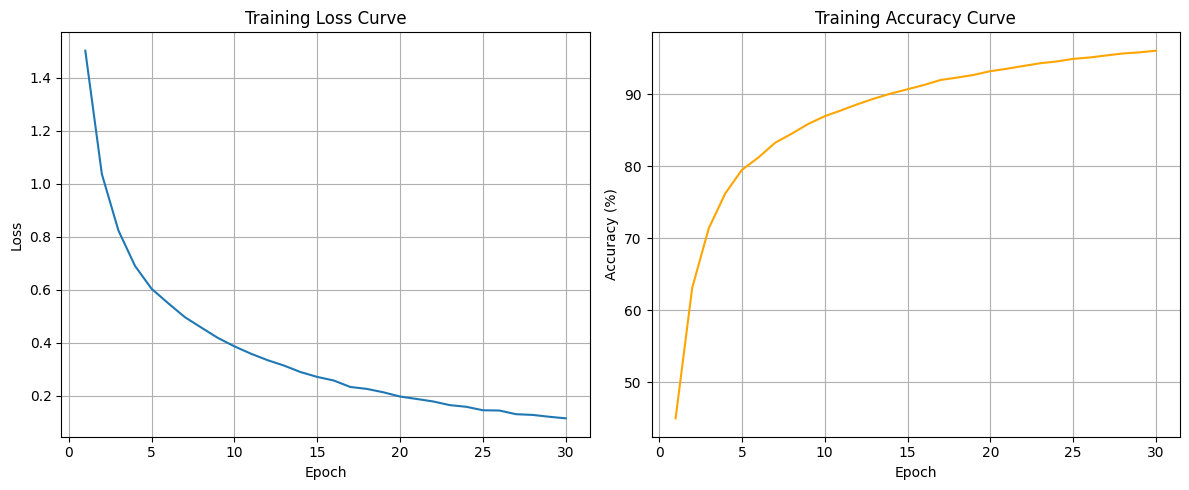

Test Accuracy: 90.80%


In [8]:
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [9]:
torch.save(model.state_dict(), "model_res_adamw.pth")

Epoch 1/30, Loss: 1.6984, Accuracy: 44.56%
Epoch 2/30, Loss: 1.3184, Accuracy: 63.96%
Epoch 3/30, Loss: 1.1528, Accuracy: 71.82%
Epoch 4/30, Loss: 1.0517, Accuracy: 76.59%
Epoch 5/30, Loss: 0.9807, Accuracy: 79.85%
Epoch 6/30, Loss: 0.9339, Accuracy: 82.18%
Epoch 7/30, Loss: 0.8943, Accuracy: 83.71%
Epoch 8/30, Loss: 0.8596, Accuracy: 85.31%
Epoch 9/30, Loss: 0.8343, Accuracy: 86.51%
Epoch 10/30, Loss: 0.8072, Accuracy: 87.65%
Epoch 11/30, Loss: 0.7874, Accuracy: 88.49%
Epoch 12/30, Loss: 0.7691, Accuracy: 89.13%
Epoch 13/30, Loss: 0.7492, Accuracy: 90.13%
Epoch 14/30, Loss: 0.7322, Accuracy: 90.96%
Epoch 15/30, Loss: 0.7208, Accuracy: 91.30%
Epoch 16/30, Loss: 0.7061, Accuracy: 92.01%
Epoch 17/30, Loss: 0.6943, Accuracy: 92.51%
Epoch 18/30, Loss: 0.6825, Accuracy: 93.06%
Epoch 19/30, Loss: 0.6749, Accuracy: 93.45%
Epoch 20/30, Loss: 0.6617, Accuracy: 93.96%
Epoch 21/30, Loss: 0.6552, Accuracy: 94.21%
Epoch 22/30, Loss: 0.6473, Accuracy: 94.57%
Epoch 23/30, Loss: 0.6412, Accuracy: 94.8

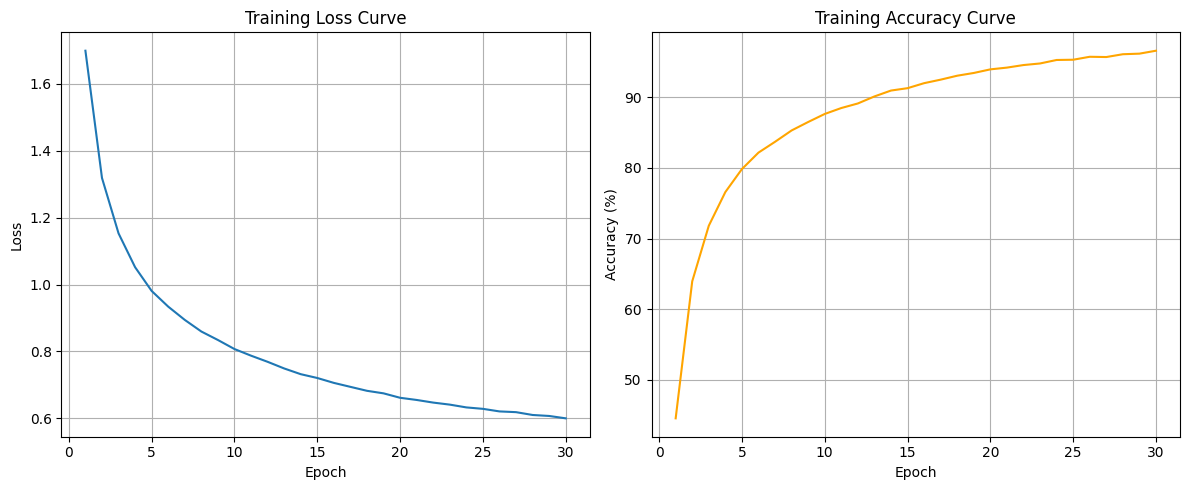

Test Accuracy: 90.71%


In [9]:
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [10]:
torch.save(model.state_dict(), "model_res_adamw_lblsmt.pth")


Epoch 1/30, Loss: 1.6467, Accuracy: 39.50%
Epoch 2/30, Loss: 1.2582, Accuracy: 54.56%
Epoch 3/30, Loss: 1.0721, Accuracy: 62.45%
Epoch 4/30, Loss: 0.9556, Accuracy: 66.93%
Epoch 5/30, Loss: 0.8667, Accuracy: 70.04%
Epoch 6/30, Loss: 0.8068, Accuracy: 72.21%
Epoch 7/30, Loss: 0.7382, Accuracy: 74.79%
Epoch 8/30, Loss: 0.6921, Accuracy: 76.34%
Epoch 9/30, Loss: 0.6469, Accuracy: 78.04%
Epoch 10/30, Loss: 0.6099, Accuracy: 79.41%
Epoch 11/30, Loss: 0.5680, Accuracy: 81.09%
Epoch 12/30, Loss: 0.5469, Accuracy: 81.65%
Epoch 13/30, Loss: 0.5034, Accuracy: 83.16%
Epoch 14/30, Loss: 0.4876, Accuracy: 83.83%
Epoch 15/30, Loss: 0.4608, Accuracy: 84.70%
Epoch 16/30, Loss: 0.4433, Accuracy: 85.25%
Epoch 17/30, Loss: 0.4214, Accuracy: 85.91%
Epoch 18/30, Loss: 0.4025, Accuracy: 86.73%
Epoch 19/30, Loss: 0.3932, Accuracy: 87.07%
Epoch 20/30, Loss: 0.3757, Accuracy: 87.49%
Epoch 21/30, Loss: 0.3679, Accuracy: 87.81%
Epoch 22/30, Loss: 0.3481, Accuracy: 88.23%
Epoch 23/30, Loss: 0.3368, Accuracy: 88.7

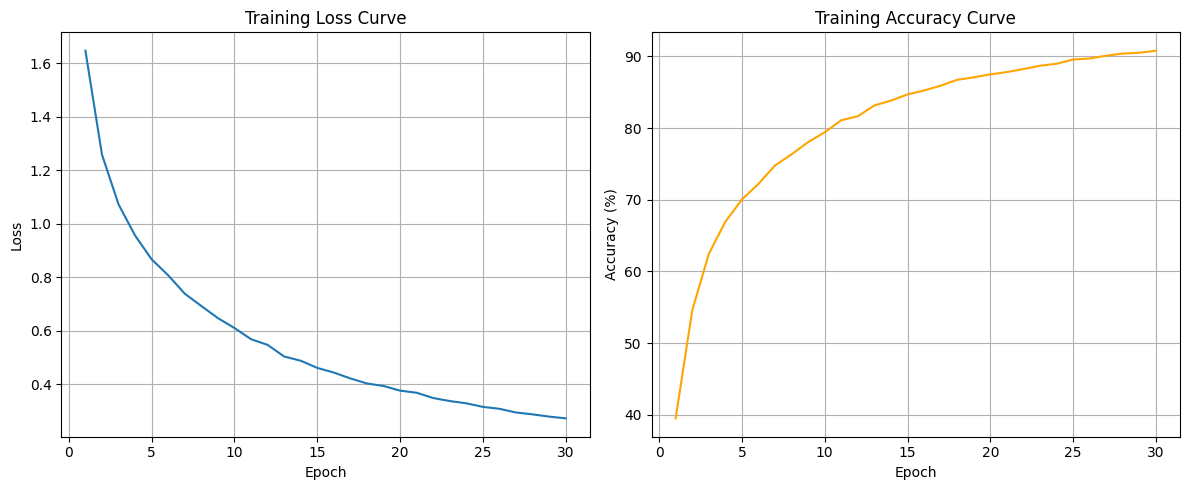

Test Accuracy: 89.30%


In [13]:
model = DeepCNN_Res(activation_fn=nn.ReLU).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [14]:
torch.save(model.state_dict(), "model_cnn_res_adamw.pth")

In [9]:

class ResNetNEO(nn.Module):
    def __init__(self):
        super(ResNetNEO, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, stride=2)   # 32 -> 16
        self.layer2 = self._make_layer(128, 256, stride=2)  # 16 -> 8
        self.layer3 = self._make_layer(256, 256, stride=2)  # 8 -> 4
        self.layer4 = self._make_layer(256, 512, stride=2)  # 4 -> 2

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, stride):
        return nn.Sequential(
            ResidualBlock(in_ch, out_ch, stride),
            ResidualBlock(out_ch, out_ch)
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


Epoch 1/30, Loss: 1.5425, Accuracy: 43.18%
Epoch 2/30, Loss: 1.0709, Accuracy: 61.73%
Epoch 3/30, Loss: 0.8569, Accuracy: 70.19%
Epoch 4/30, Loss: 0.7241, Accuracy: 75.02%
Epoch 5/30, Loss: 0.6261, Accuracy: 78.66%
Epoch 6/30, Loss: 0.5648, Accuracy: 80.75%
Epoch 7/30, Loss: 0.5100, Accuracy: 82.82%
Epoch 8/30, Loss: 0.4714, Accuracy: 83.93%
Epoch 9/30, Loss: 0.4313, Accuracy: 85.37%
Epoch 10/30, Loss: 0.3955, Accuracy: 86.55%
Epoch 11/30, Loss: 0.3677, Accuracy: 87.50%
Epoch 12/30, Loss: 0.3387, Accuracy: 88.51%
Epoch 13/30, Loss: 0.3201, Accuracy: 89.13%
Epoch 14/30, Loss: 0.2987, Accuracy: 89.85%
Epoch 15/30, Loss: 0.2821, Accuracy: 90.39%
Epoch 16/30, Loss: 0.2641, Accuracy: 91.08%
Epoch 17/30, Loss: 0.2457, Accuracy: 91.52%
Epoch 18/30, Loss: 0.2318, Accuracy: 92.15%
Epoch 19/30, Loss: 0.2150, Accuracy: 92.74%
Epoch 20/30, Loss: 0.2049, Accuracy: 93.00%
Epoch 21/30, Loss: 0.1941, Accuracy: 93.41%
Epoch 22/30, Loss: 0.1826, Accuracy: 93.78%
Epoch 23/30, Loss: 0.1707, Accuracy: 94.1

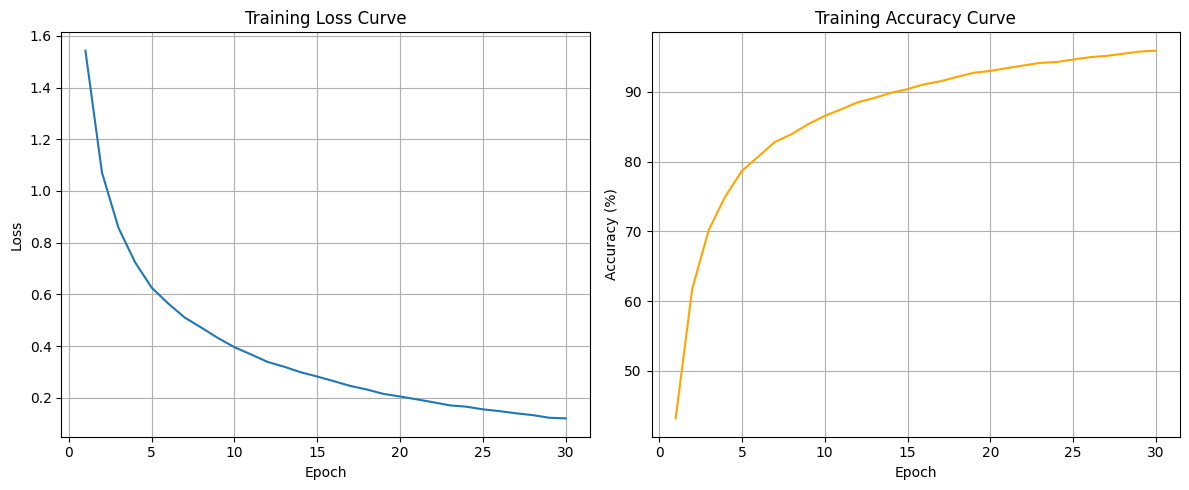

Test Accuracy: 90.97%


In [10]:
model = ResNetNEO().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [11]:
torch.save(model.state_dict(), "model_resneo_adamw.pth")

Epoch 1/50, Loss: 1.5548, Accuracy: 42.57%
Epoch 2/50, Loss: 1.0740, Accuracy: 61.78%
Epoch 3/50, Loss: 0.8621, Accuracy: 69.81%
Epoch 4/50, Loss: 0.7357, Accuracy: 74.45%
Epoch 5/50, Loss: 0.6378, Accuracy: 78.14%
Epoch 6/50, Loss: 0.5738, Accuracy: 80.38%
Epoch 7/50, Loss: 0.5163, Accuracy: 82.34%
Epoch 8/50, Loss: 0.4717, Accuracy: 84.01%
Epoch 9/50, Loss: 0.4381, Accuracy: 85.03%
Epoch 10/50, Loss: 0.4039, Accuracy: 86.27%
Epoch 11/50, Loss: 0.3734, Accuracy: 87.44%
Epoch 12/50, Loss: 0.3462, Accuracy: 88.12%
Epoch 13/50, Loss: 0.3193, Accuracy: 89.02%
Epoch 14/50, Loss: 0.2982, Accuracy: 89.76%
Epoch 15/50, Loss: 0.2803, Accuracy: 90.51%
Epoch 16/50, Loss: 0.2650, Accuracy: 90.91%
Epoch 17/50, Loss: 0.2495, Accuracy: 91.51%
Epoch 18/50, Loss: 0.2347, Accuracy: 92.05%
Epoch 19/50, Loss: 0.2224, Accuracy: 92.32%
Epoch 20/50, Loss: 0.2094, Accuracy: 92.74%
Epoch 21/50, Loss: 0.1908, Accuracy: 93.42%
Epoch 22/50, Loss: 0.1816, Accuracy: 93.83%
Epoch 23/50, Loss: 0.1731, Accuracy: 94.0

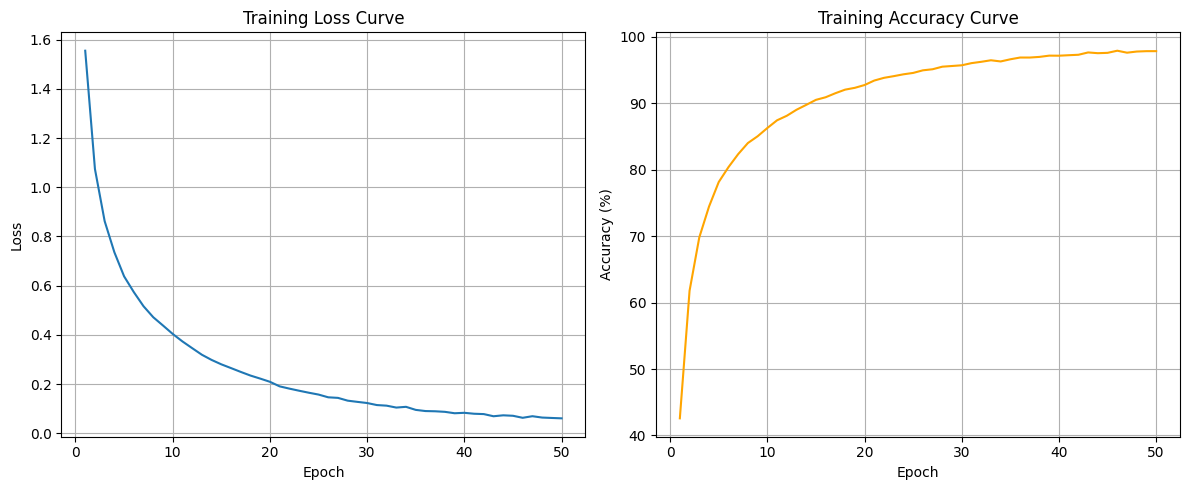

Test Accuracy: 91.47%


In [10]:
model = ResNetNEO().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [11]:
torch.save(model.state_dict(), "model_resneo_adamw_50epo.pth")

Epoch 1/30, Loss: 1.5668, Accuracy: 42.48%
Epoch 2/30, Loss: 1.0825, Accuracy: 61.54%
Epoch 3/30, Loss: 0.8555, Accuracy: 70.12%
Epoch 4/30, Loss: 0.7265, Accuracy: 74.71%
Epoch 5/30, Loss: 0.6358, Accuracy: 78.23%
Epoch 6/30, Loss: 0.5658, Accuracy: 80.65%
Epoch 7/30, Loss: 0.5130, Accuracy: 82.61%
Epoch 8/30, Loss: 0.4657, Accuracy: 84.23%
Epoch 9/30, Loss: 0.4317, Accuracy: 85.26%
Epoch 10/30, Loss: 0.3964, Accuracy: 86.48%
Epoch 11/30, Loss: 0.3685, Accuracy: 87.47%
Epoch 12/30, Loss: 0.3402, Accuracy: 88.42%
Epoch 13/30, Loss: 0.3125, Accuracy: 89.32%
Epoch 14/30, Loss: 0.2982, Accuracy: 89.85%
Epoch 15/30, Loss: 0.2733, Accuracy: 90.67%
Epoch 16/30, Loss: 0.2614, Accuracy: 91.14%
Epoch 17/30, Loss: 0.2389, Accuracy: 91.82%
Epoch 18/30, Loss: 0.2267, Accuracy: 92.07%
Epoch 19/30, Loss: 0.2100, Accuracy: 92.95%
Epoch 20/30, Loss: 0.2045, Accuracy: 93.10%
Epoch 21/30, Loss: 0.1908, Accuracy: 93.53%
Epoch 22/30, Loss: 0.1819, Accuracy: 93.80%
Epoch 23/30, Loss: 0.1666, Accuracy: 94.2

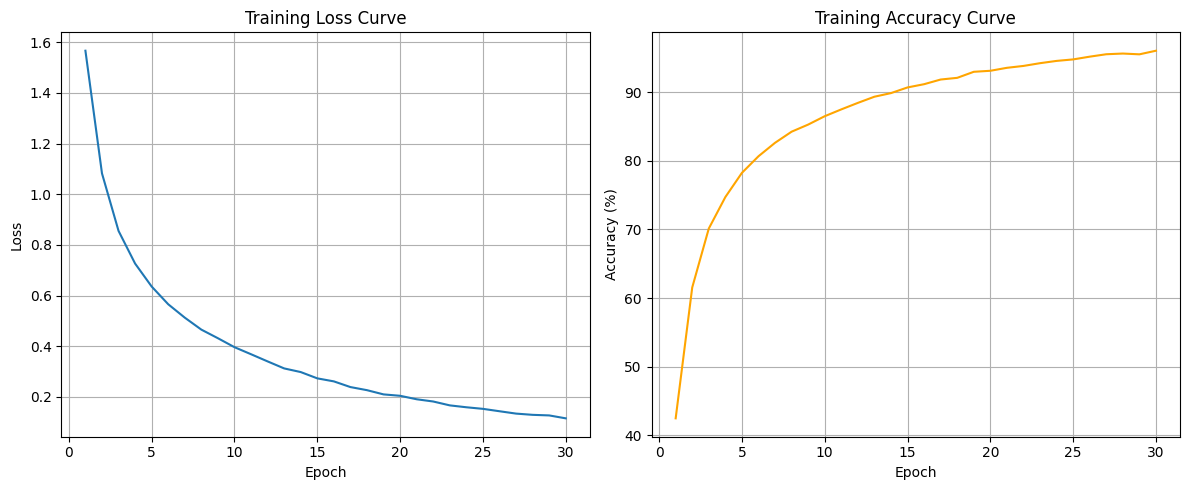

Test Accuracy: 90.94%


In [12]:
model = ResNetNEO().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [13]:
torch.save(model.state_dict(), "model_resneo_adamw_coslr.pth")

## Bottleneck

In [8]:
import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channel, channel // reduction),
            nn.ReLU(),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.fc(x).view(x.size(0), x.size(1), 1, 1)
        return x * scale

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.se = SEBlock(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.se(out)
        out = out + identity
        out = self.relu(out)
        return out

class ResNetBottle(nn.Module):
    def __init__(self):
        super(ResNetBottle, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(64, 64, 256, num_blocks=3, stride=1)
        self.layer2 = self._make_layer(256, 128, 512, num_blocks=3, stride=2)
        self.layer3 = self._make_layer(512, 256, 1024, num_blocks=3, stride=2)
        self.layer4 = self._make_layer(1024, 512, 2048, num_blocks=3, stride=2)
        self.layer5 = self._make_layer(2048, 1024, 4096, num_blocks=2, stride=2)  # 2x2 -> 1x1


        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )

    def _make_layer(self, in_ch, mid_ch, out_ch, num_blocks, stride):
        layers = [BottleneckBlock(in_ch, mid_ch, out_ch, stride)]
        for _ in range(1, num_blocks):
            layers.append(BottleneckBlock(out_ch, mid_ch, out_ch, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)  # [B, 256, 32, 32]
        x = self.layer2(x)  # [B, 512, 16, 16]
        x = self.layer3(x)  # [B, 1024, 8, 8]
        x = self.layer4(x)  # [B, 2048, 4, 4]
        x = self.layer5(x)  # [B, 4096, 2, 2]
        x = self.pool(x)    # [B, 2048, 1, 1]
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Epoch 1/30, Loss: 1.7655, Accuracy: 36.51%
Epoch 2/30, Loss: 1.2675, Accuracy: 54.35%
Epoch 3/30, Loss: 1.0168, Accuracy: 64.05%
Epoch 4/30, Loss: 0.8724, Accuracy: 69.45%
Epoch 5/30, Loss: 0.7585, Accuracy: 73.56%
Epoch 6/30, Loss: 0.6748, Accuracy: 76.78%
Epoch 7/30, Loss: 0.5984, Accuracy: 79.37%
Epoch 8/30, Loss: 0.5587, Accuracy: 80.92%
Epoch 9/30, Loss: 0.5046, Accuracy: 82.78%
Epoch 10/30, Loss: 0.4733, Accuracy: 83.83%
Epoch 11/30, Loss: 0.4339, Accuracy: 85.16%
Epoch 12/30, Loss: 0.4262, Accuracy: 85.43%
Epoch 13/30, Loss: 0.3815, Accuracy: 86.75%
Epoch 14/30, Loss: 0.3526, Accuracy: 87.93%
Epoch 15/30, Loss: 0.3351, Accuracy: 88.59%
Epoch 16/30, Loss: 0.3179, Accuracy: 89.21%
Epoch 17/30, Loss: 0.2969, Accuracy: 89.92%
Epoch 18/30, Loss: 0.2851, Accuracy: 90.24%
Epoch 19/30, Loss: 0.2697, Accuracy: 90.79%
Epoch 20/30, Loss: 0.2488, Accuracy: 91.43%
Epoch 21/30, Loss: 0.2382, Accuracy: 91.85%
Epoch 22/30, Loss: 0.2325, Accuracy: 92.06%
Epoch 23/30, Loss: 0.2202, Accuracy: 92.3

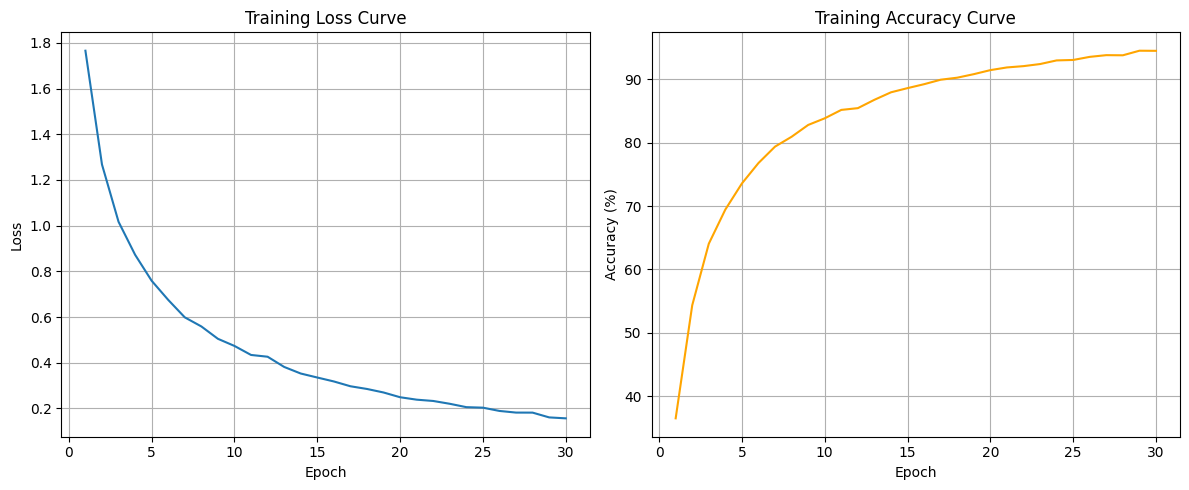

Test Accuracy: 90.34%


In [9]:
model = ResNetBottle().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

# 

In [10]:
torch.save(model.state_dict(), "model_res_bottleneck.pth")

In [9]:

class ResNetNEO5(nn.Module):
    def __init__(self):
        super(ResNetNEO5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, stride=2)   # 32 -> 16
        self.layer2 = self._make_layer(128, 256, stride=2)  # 16 -> 8
        self.layer3 = self._make_layer(256, 256, stride=2)  # 8 -> 4
        self.layer4 = self._make_layer(256, 512, stride=2)  # 4 -> 2
        self.layer5 = self._make_layer(512, 1024, stride=2)  # 2 -> 1


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, stride):
        return nn.Sequential(
            ResidualBlock(in_ch, out_ch, stride),
            ResidualBlock(out_ch, out_ch)
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Epoch 1/30, Loss: 1.7479, Accuracy: 34.97%
Epoch 2/30, Loss: 1.3678, Accuracy: 50.58%
Epoch 3/30, Loss: 1.1022, Accuracy: 61.03%
Epoch 4/30, Loss: 0.9357, Accuracy: 67.51%
Epoch 5/30, Loss: 0.8195, Accuracy: 71.84%
Epoch 6/30, Loss: 0.7354, Accuracy: 74.82%
Epoch 7/30, Loss: 0.6668, Accuracy: 77.29%
Epoch 8/30, Loss: 0.6093, Accuracy: 79.20%
Epoch 9/30, Loss: 0.5578, Accuracy: 80.95%
Epoch 10/30, Loss: 0.5141, Accuracy: 82.66%
Epoch 11/30, Loss: 0.4819, Accuracy: 83.58%
Epoch 12/30, Loss: 0.4465, Accuracy: 84.85%
Epoch 13/30, Loss: 0.4147, Accuracy: 85.96%
Epoch 14/30, Loss: 0.3877, Accuracy: 86.79%
Epoch 15/30, Loss: 0.3666, Accuracy: 87.44%
Epoch 16/30, Loss: 0.3431, Accuracy: 88.38%
Epoch 17/30, Loss: 0.3204, Accuracy: 89.00%
Epoch 18/30, Loss: 0.3069, Accuracy: 89.67%
Epoch 19/30, Loss: 0.2869, Accuracy: 90.34%
Epoch 20/30, Loss: 0.2686, Accuracy: 90.97%
Epoch 21/30, Loss: 0.2581, Accuracy: 91.21%
Epoch 22/30, Loss: 0.2367, Accuracy: 91.86%
Epoch 23/30, Loss: 0.2271, Accuracy: 92.1

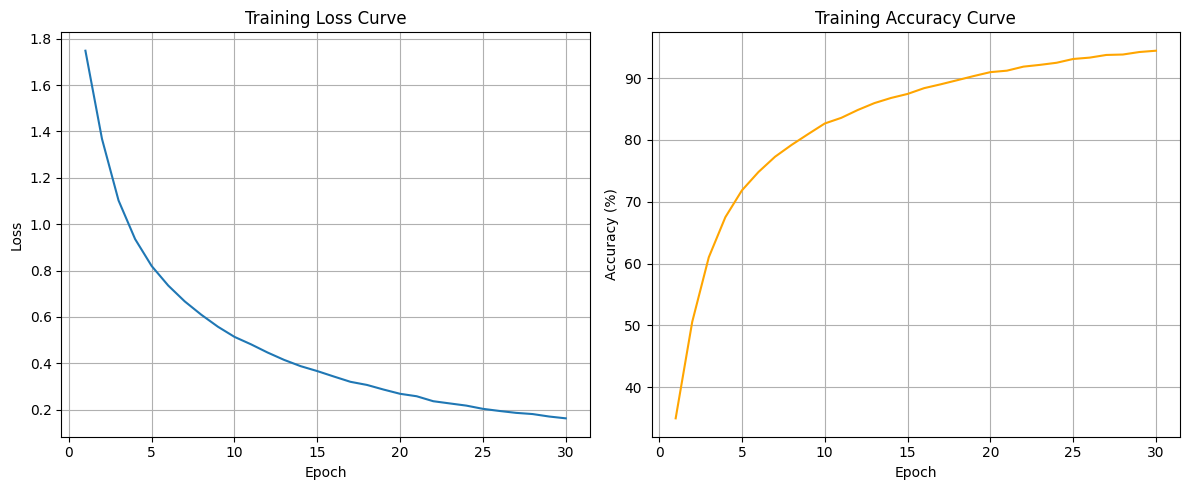

Test Accuracy: 89.77%


In [10]:
model = ResNetNEO5().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=30)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [11]:
torch.save(model.state_dict(), "model_res_5layer.pth")

In [18]:
class ResNetNEO3463(nn.Module):
    def __init__(self):
        super(ResNetNEO3463, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, num_blocks=3, stride=2)
        self.layer2 = self._make_layer(128, 256, num_blocks=4, stride=2)
        self.layer3 = self._make_layer(256, 256, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_ch, out_ch, stride))  # 第一个 block 做降采样
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_ch, out_ch))  # 之后保持通道一致
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Epoch 1/50, Loss: 1.7166, Accuracy: 36.04%
Epoch 2/50, Loss: 1.2032, Accuracy: 56.96%
Epoch 3/50, Loss: 0.9459, Accuracy: 66.77%
Epoch 4/50, Loss: 0.7878, Accuracy: 72.66%
Epoch 5/50, Loss: 0.6895, Accuracy: 76.40%
Epoch 6/50, Loss: 0.6090, Accuracy: 79.16%
Epoch 7/50, Loss: 0.5478, Accuracy: 81.35%
Epoch 8/50, Loss: 0.4949, Accuracy: 83.17%
Epoch 9/50, Loss: 0.4577, Accuracy: 84.42%
Epoch 10/50, Loss: 0.4211, Accuracy: 85.71%
Epoch 11/50, Loss: 0.3919, Accuracy: 86.85%
Epoch 12/50, Loss: 0.3624, Accuracy: 87.63%
Epoch 13/50, Loss: 0.3324, Accuracy: 88.70%
Epoch 14/50, Loss: 0.3147, Accuracy: 89.25%
Epoch 15/50, Loss: 0.2888, Accuracy: 90.20%
Epoch 16/50, Loss: 0.2745, Accuracy: 90.64%
Epoch 17/50, Loss: 0.2522, Accuracy: 91.36%
Epoch 18/50, Loss: 0.2377, Accuracy: 91.90%
Epoch 19/50, Loss: 0.2253, Accuracy: 92.36%
Epoch 20/50, Loss: 0.2127, Accuracy: 92.76%
Epoch 21/50, Loss: 0.1977, Accuracy: 93.21%
Epoch 22/50, Loss: 0.1862, Accuracy: 93.68%
Epoch 23/50, Loss: 0.1723, Accuracy: 94.1

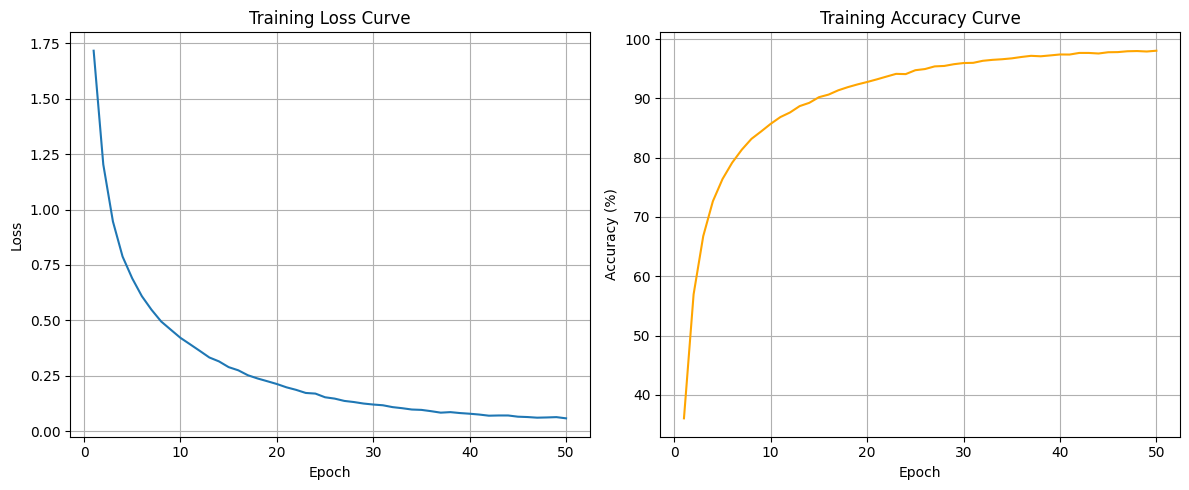

Test Accuracy: 91.52%


In [20]:
model = ResNetNEO3463().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [21]:
torch.save(model.state_dict(), "model_res3463_coslr.pth")

In [ ]:
class ResNetNEO3463_7(nn.Module):
    def __init__(self):
        super(ResNetNEO3463, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, num_blocks=3, stride=2)
        self.layer2 = self._make_layer(128, 256, num_blocks=4, stride=2)
        self.layer3 = self._make_layer(256, 256, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_ch, out_ch, stride))  # 第一个 block 做降采样
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_ch, out_ch))  # 之后保持通道一致
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model = ResNetNEO3463_7().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

Epoch 1/50, Loss: 1.7443, Accuracy: 34.20%
Epoch 2/50, Loss: 1.2246, Accuracy: 55.76%
Epoch 3/50, Loss: 0.9652, Accuracy: 66.04%
Epoch 4/50, Loss: 0.7991, Accuracy: 72.32%
Epoch 5/50, Loss: 0.6931, Accuracy: 76.32%
Epoch 6/50, Loss: 0.6169, Accuracy: 78.98%
Epoch 7/50, Loss: 0.5510, Accuracy: 81.23%
Epoch 8/50, Loss: 0.5015, Accuracy: 82.91%
Epoch 9/50, Loss: 0.4609, Accuracy: 84.43%
Epoch 10/50, Loss: 0.4250, Accuracy: 85.62%
Epoch 11/50, Loss: 0.3936, Accuracy: 86.62%
Epoch 12/50, Loss: 0.3616, Accuracy: 87.73%
Epoch 13/50, Loss: 0.3357, Accuracy: 88.56%
Epoch 14/50, Loss: 0.3178, Accuracy: 89.13%
Epoch 15/50, Loss: 0.2881, Accuracy: 90.21%
Epoch 16/50, Loss: 0.2753, Accuracy: 90.60%
Epoch 17/50, Loss: 0.2558, Accuracy: 91.32%
Epoch 18/50, Loss: 0.2446, Accuracy: 91.60%
Epoch 19/50, Loss: 0.2212, Accuracy: 92.46%
Epoch 20/50, Loss: 0.2146, Accuracy: 92.63%
Epoch 21/50, Loss: 0.1991, Accuracy: 93.37%
Epoch 22/50, Loss: 0.1869, Accuracy: 93.69%
Epoch 23/50, Loss: 0.1756, Accuracy: 93.8

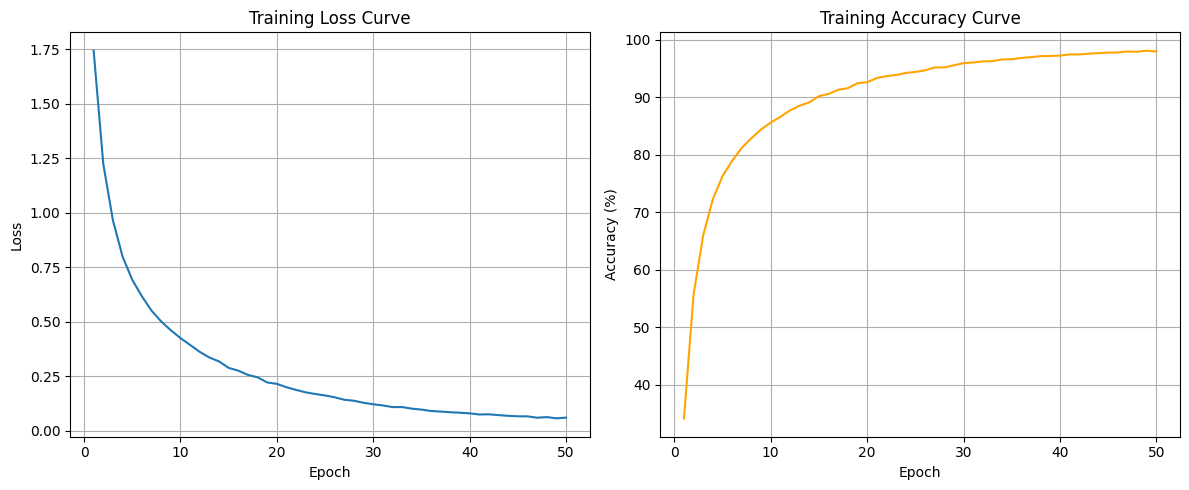

Test Accuracy: 91.63%


In [24]:
model = ResNetNEO3463().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [25]:
torch.save(model.state_dict(), "model_res3463_steplr.pth")

In [7]:
class ResNetNEO3663(nn.Module):
    def __init__(self):
        super(ResNetNEO3663, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, num_blocks=3, stride=2)
        self.layer2 = self._make_layer(128, 256, num_blocks=6, stride=2)
        self.layer3 = self._make_layer(256, 256, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_ch, out_ch, stride))  # 第一个 block 做降采样
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_ch, out_ch))  # 之后保持通道一致
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Epoch 1/50, Loss: 1.7421, Accuracy: 34.50%
Epoch 2/50, Loss: 1.2345, Accuracy: 55.44%
Epoch 3/50, Loss: 0.9787, Accuracy: 65.49%
Epoch 4/50, Loss: 0.8237, Accuracy: 71.20%
Epoch 5/50, Loss: 0.7068, Accuracy: 75.56%
Epoch 6/50, Loss: 0.6311, Accuracy: 78.32%
Epoch 7/50, Loss: 0.5675, Accuracy: 80.65%
Epoch 8/50, Loss: 0.5111, Accuracy: 82.72%
Epoch 9/50, Loss: 0.4717, Accuracy: 84.00%
Epoch 10/50, Loss: 0.4342, Accuracy: 85.31%
Epoch 11/50, Loss: 0.3978, Accuracy: 86.51%
Epoch 12/50, Loss: 0.3751, Accuracy: 87.35%
Epoch 13/50, Loss: 0.3434, Accuracy: 88.22%
Epoch 14/50, Loss: 0.3225, Accuracy: 89.12%
Epoch 15/50, Loss: 0.3001, Accuracy: 89.91%
Epoch 16/50, Loss: 0.2769, Accuracy: 90.50%
Epoch 17/50, Loss: 0.2610, Accuracy: 91.10%
Epoch 18/50, Loss: 0.2468, Accuracy: 91.51%
Epoch 19/50, Loss: 0.2280, Accuracy: 92.20%
Epoch 20/50, Loss: 0.2162, Accuracy: 92.62%
Epoch 21/50, Loss: 0.2057, Accuracy: 93.02%
Epoch 22/50, Loss: 0.1923, Accuracy: 93.40%
Epoch 23/50, Loss: 0.1816, Accuracy: 93.8

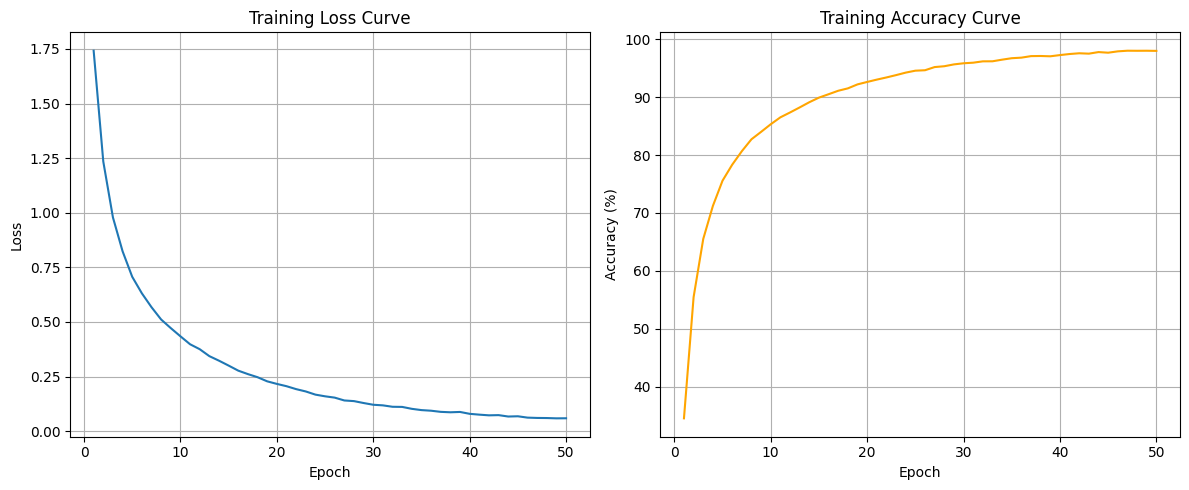

Test Accuracy: 91.96%


In [9]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [12]:
torch.save(model.state_dict(), "model_res3663_steplr_50epo.pth")

In [7]:
class ResNetNEO3683(nn.Module):
    def __init__(self):
        super(ResNetNEO3683, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, num_blocks=3, stride=2)
        self.layer2 = self._make_layer(128, 256, num_blocks=6, stride=2)
        self.layer3 = self._make_layer(256, 256, num_blocks=8, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_ch, out_ch, stride))  # 第一个 block 做降采样
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_ch, out_ch))  # 之后保持通道一致
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Epoch 1/50, Loss: 1.7237, Accuracy: 34.91%
Epoch 2/50, Loss: 1.2290, Accuracy: 55.50%
Epoch 3/50, Loss: 0.9806, Accuracy: 65.50%
Epoch 4/50, Loss: 0.8223, Accuracy: 71.46%
Epoch 5/50, Loss: 0.7085, Accuracy: 75.61%
Epoch 6/50, Loss: 0.6305, Accuracy: 78.42%
Epoch 7/50, Loss: 0.5670, Accuracy: 80.87%
Epoch 8/50, Loss: 0.5121, Accuracy: 82.61%
Epoch 9/50, Loss: 0.4755, Accuracy: 83.77%
Epoch 10/50, Loss: 0.4319, Accuracy: 85.38%
Epoch 11/50, Loss: 0.3993, Accuracy: 86.42%
Epoch 12/50, Loss: 0.3737, Accuracy: 87.27%
Epoch 13/50, Loss: 0.3400, Accuracy: 88.50%
Epoch 14/50, Loss: 0.3207, Accuracy: 89.14%
Epoch 15/50, Loss: 0.2994, Accuracy: 89.82%
Epoch 16/50, Loss: 0.2747, Accuracy: 90.72%
Epoch 17/50, Loss: 0.2619, Accuracy: 91.05%
Epoch 18/50, Loss: 0.2430, Accuracy: 91.66%
Epoch 19/50, Loss: 0.2255, Accuracy: 92.37%
Epoch 20/50, Loss: 0.2143, Accuracy: 92.65%
Epoch 21/50, Loss: 0.1996, Accuracy: 93.12%
Epoch 22/50, Loss: 0.1858, Accuracy: 93.69%
Epoch 23/50, Loss: 0.1772, Accuracy: 93.9

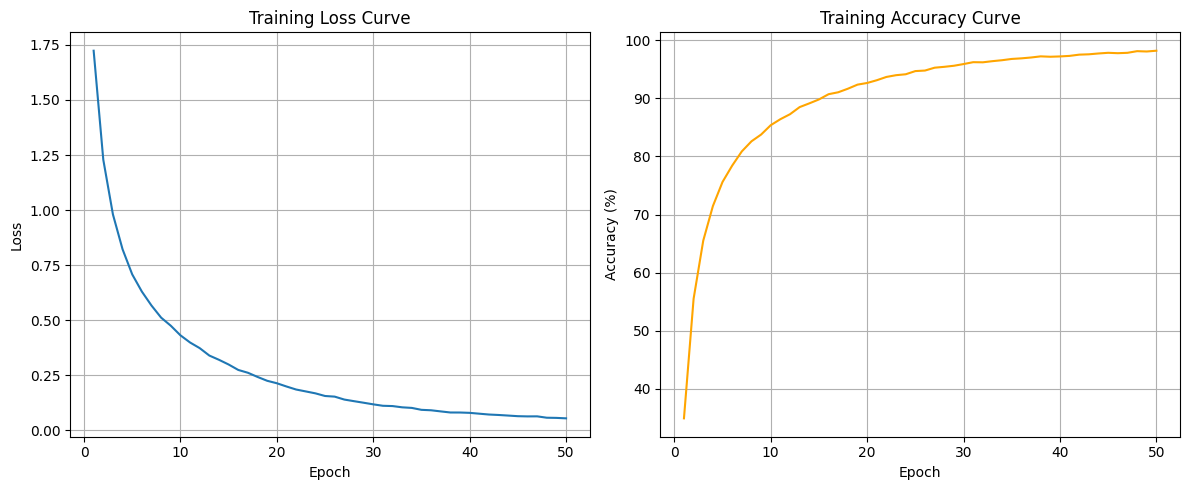

Test Accuracy: 91.40%


In [8]:
model = ResNetNEO3683().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [9]:
torch.save(model.state_dict(), "model_res3683_steplr_50epo.pth")

Epoch 1/50, Loss: 1.8813, Accuracy: 34.48%
Epoch 2/50, Loss: 1.5010, Accuracy: 54.05%
Epoch 3/50, Loss: 1.2943, Accuracy: 64.56%
Epoch 4/50, Loss: 1.1627, Accuracy: 71.11%
Epoch 5/50, Loss: 1.0762, Accuracy: 74.97%
Epoch 6/50, Loss: 1.0597, Accuracy: 75.99%
Epoch 7/50, Loss: 0.9616, Accuracy: 80.21%
Epoch 8/50, Loss: 0.9306, Accuracy: 81.70%
Epoch 9/50, Loss: 0.8992, Accuracy: 83.02%
Epoch 10/50, Loss: 0.8858, Accuracy: 83.48%
Epoch 11/50, Loss: 0.8538, Accuracy: 85.12%
Epoch 12/50, Loss: 0.8294, Accuracy: 86.13%
Epoch 13/50, Loss: 0.8051, Accuracy: 87.10%
Epoch 14/50, Loss: 0.7939, Accuracy: 87.64%
Epoch 15/50, Loss: 0.7740, Accuracy: 88.70%
Epoch 16/50, Loss: 0.7823, Accuracy: 88.07%
Epoch 17/50, Loss: 0.7344, Accuracy: 90.31%
Epoch 18/50, Loss: 0.7297, Accuracy: 90.40%
Epoch 19/50, Loss: 0.7289, Accuracy: 90.46%
Epoch 20/50, Loss: 0.7040, Accuracy: 91.57%
Epoch 21/50, Loss: 0.6989, Accuracy: 91.75%
Epoch 22/50, Loss: 0.7318, Accuracy: 90.37%
Epoch 23/50, Loss: 0.6709, Accuracy: 93.0

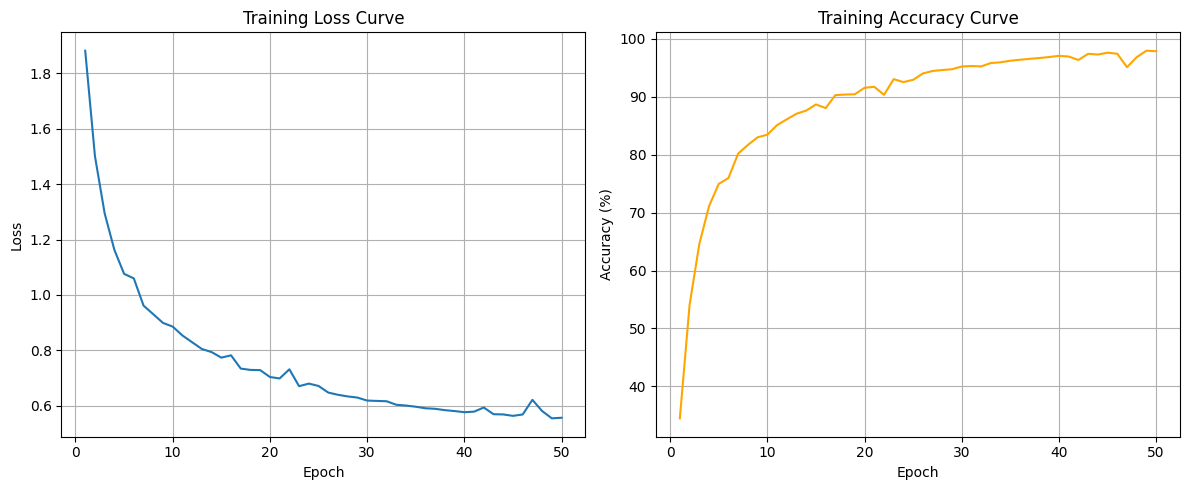

Test Accuracy: 91.28%


In [8]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [9]:
torch.save(model.state_dict(), "model_res3683_steplr_50epo_smtlbl.pth")

In [9]:
class ResidualBlock_leaky(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock_leaky, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # 残差连接
        out = self.relu(out)
        return out

class ResNetNEO3683_leaky(nn.Module):
    def __init__(self):
        super(ResNetNEO3683_leaky, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, num_blocks=3, stride=2)
        self.layer2 = self._make_layer(128, 256, num_blocks=6, stride=2)
        self.layer3 = self._make_layer(256, 256, num_blocks=8, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock_leaky(in_ch, out_ch, stride))  # 第一个 block 做降采样
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock_leaky(out_ch, out_ch))  # 之后保持通道一致
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Epoch 1/50, Loss: 1.7955, Accuracy: 32.48%
Epoch 2/50, Loss: 1.3457, Accuracy: 50.64%
Epoch 3/50, Loss: 1.0663, Accuracy: 62.20%
Epoch 4/50, Loss: 0.8923, Accuracy: 68.84%
Epoch 5/50, Loss: 0.7916, Accuracy: 72.61%
Epoch 6/50, Loss: 0.6879, Accuracy: 76.29%
Epoch 7/50, Loss: 0.6094, Accuracy: 79.22%
Epoch 8/50, Loss: 0.5614, Accuracy: 80.86%
Epoch 9/50, Loss: 0.5112, Accuracy: 82.51%
Epoch 10/50, Loss: 0.4675, Accuracy: 84.12%
Epoch 11/50, Loss: 0.4327, Accuracy: 85.37%
Epoch 12/50, Loss: 0.3946, Accuracy: 86.60%
Epoch 13/50, Loss: 0.3710, Accuracy: 87.38%
Epoch 14/50, Loss: 0.3432, Accuracy: 88.36%
Epoch 15/50, Loss: 0.3317, Accuracy: 88.69%
Epoch 16/50, Loss: 0.3090, Accuracy: 89.53%
Epoch 17/50, Loss: 0.2879, Accuracy: 90.24%
Epoch 18/50, Loss: 0.2660, Accuracy: 90.94%
Epoch 19/50, Loss: 0.2884, Accuracy: 90.27%
Epoch 20/50, Loss: 0.2343, Accuracy: 91.96%
Epoch 21/50, Loss: 0.2170, Accuracy: 92.58%
Epoch 22/50, Loss: 0.2117, Accuracy: 92.85%
Epoch 23/50, Loss: 0.1975, Accuracy: 93.2

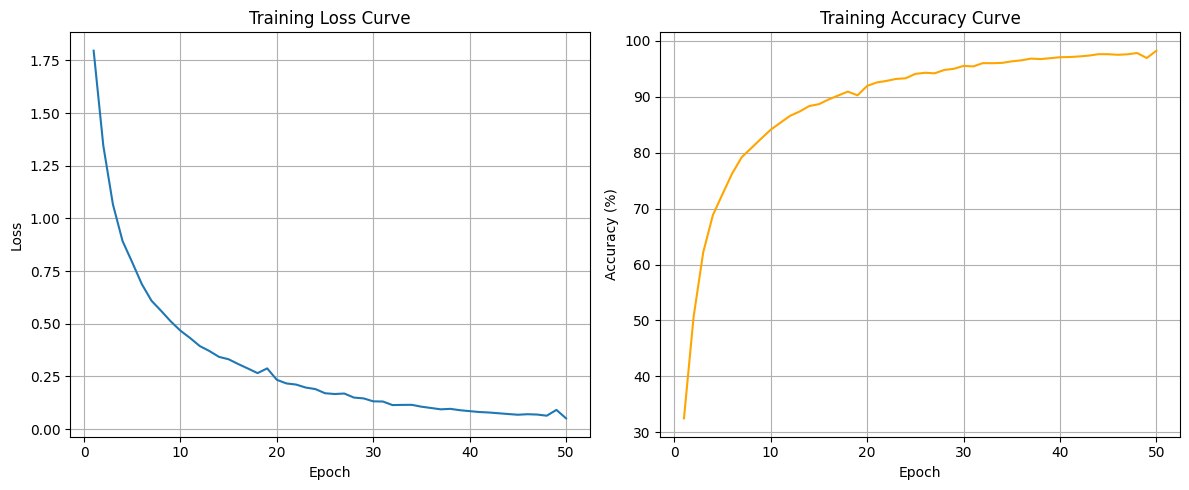

Test Accuracy: 91.76%


In [10]:
model = ResNetNEO3683_leaky().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [11]:
torch.save(model.state_dict(), "model_res3683_steplr_50epo_leaky.pth")

In [6]:
class ResidualBlock_gelu(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock_gelu, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.gelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # 残差连接
        out = self.gelu(out)
        return out

class ResNetNEO3663_GELU(nn.Module):
    def __init__(self):
        super(ResNetNEO3663_GELU, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.gelu = nn.GELU()

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, num_blocks=3, stride=2)
        self.layer2 = self._make_layer(128, 256, num_blocks=6, stride=2)
        self.layer3 = self._make_layer(256, 256, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock_gelu(in_ch, out_ch, stride))  # 第一个 block 做降采样
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock_gelu(out_ch, out_ch))  # 之后保持通道一致
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.gelu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Epoch 1/50, Loss: 1.8357, Accuracy: 31.31%
Epoch 2/50, Loss: 1.3472, Accuracy: 50.81%
Epoch 3/50, Loss: 1.0868, Accuracy: 61.54%
Epoch 4/50, Loss: 0.8861, Accuracy: 69.12%
Epoch 5/50, Loss: 0.7732, Accuracy: 73.38%
Epoch 6/50, Loss: 0.7922, Accuracy: 72.69%
Epoch 7/50, Loss: 0.6202, Accuracy: 78.94%
Epoch 8/50, Loss: 0.5677, Accuracy: 80.87%
Epoch 9/50, Loss: 0.5179, Accuracy: 82.58%
Epoch 10/50, Loss: 0.4967, Accuracy: 83.23%
Epoch 11/50, Loss: 0.4450, Accuracy: 84.93%
Epoch 12/50, Loss: 0.4104, Accuracy: 86.10%
Epoch 13/50, Loss: 0.3815, Accuracy: 86.99%
Epoch 14/50, Loss: 0.4053, Accuracy: 86.30%
Epoch 15/50, Loss: 0.3870, Accuracy: 86.90%
Epoch 16/50, Loss: 0.3249, Accuracy: 89.02%
Epoch 17/50, Loss: 0.2997, Accuracy: 89.65%
Epoch 18/50, Loss: 0.2937, Accuracy: 90.04%
Epoch 19/50, Loss: 0.2586, Accuracy: 91.12%
Epoch 20/50, Loss: 0.2451, Accuracy: 91.66%
Epoch 21/50, Loss: 0.2410, Accuracy: 91.71%
Epoch 22/50, Loss: 0.2208, Accuracy: 92.38%
Epoch 23/50, Loss: 0.2047, Accuracy: 92.9

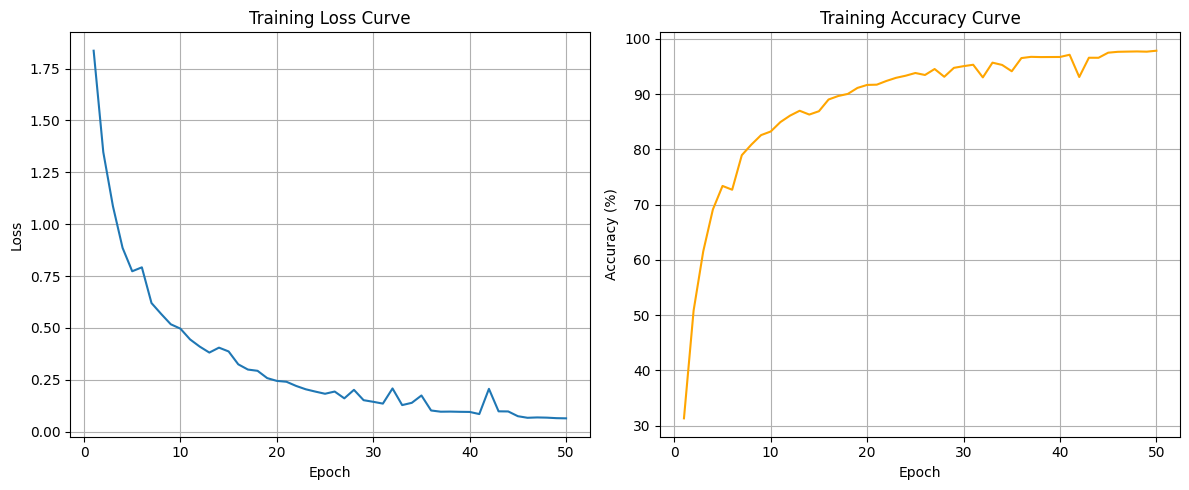

Test Accuracy: 91.70%


In [7]:
model = ResNetNEO3663_GELU().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [8]:
torch.save(model.state_dict(), "model_res3663_steplr_50epo_gelu.pth") 

Epoch 1/80, Loss: 1.7962, Accuracy: 32.96%
Epoch 2/80, Loss: 1.3169, Accuracy: 51.74%
Epoch 3/80, Loss: 1.0485, Accuracy: 62.83%
Epoch 4/80, Loss: 0.8502, Accuracy: 70.34%
Epoch 5/80, Loss: 0.7323, Accuracy: 74.75%
Epoch 6/80, Loss: 0.6534, Accuracy: 77.66%
Epoch 7/80, Loss: 0.5816, Accuracy: 80.18%
Epoch 8/80, Loss: 0.5267, Accuracy: 82.24%
Epoch 9/80, Loss: 0.4827, Accuracy: 83.59%
Epoch 10/80, Loss: 0.4464, Accuracy: 84.77%
Epoch 11/80, Loss: 0.4096, Accuracy: 85.96%
Epoch 12/80, Loss: 0.3727, Accuracy: 87.38%
Epoch 13/80, Loss: 0.3467, Accuracy: 88.11%
Epoch 14/80, Loss: 0.3325, Accuracy: 88.74%
Epoch 15/80, Loss: 0.3058, Accuracy: 89.57%
Epoch 16/80, Loss: 0.2904, Accuracy: 90.07%
Epoch 17/80, Loss: 0.2706, Accuracy: 90.70%
Epoch 18/80, Loss: 0.2538, Accuracy: 91.27%
Epoch 19/80, Loss: 0.2343, Accuracy: 92.01%
Epoch 20/80, Loss: 0.2222, Accuracy: 92.36%
Epoch 21/80, Loss: 0.2070, Accuracy: 93.06%
Epoch 22/80, Loss: 0.2022, Accuracy: 93.10%
Epoch 23/80, Loss: 0.1823, Accuracy: 93.7

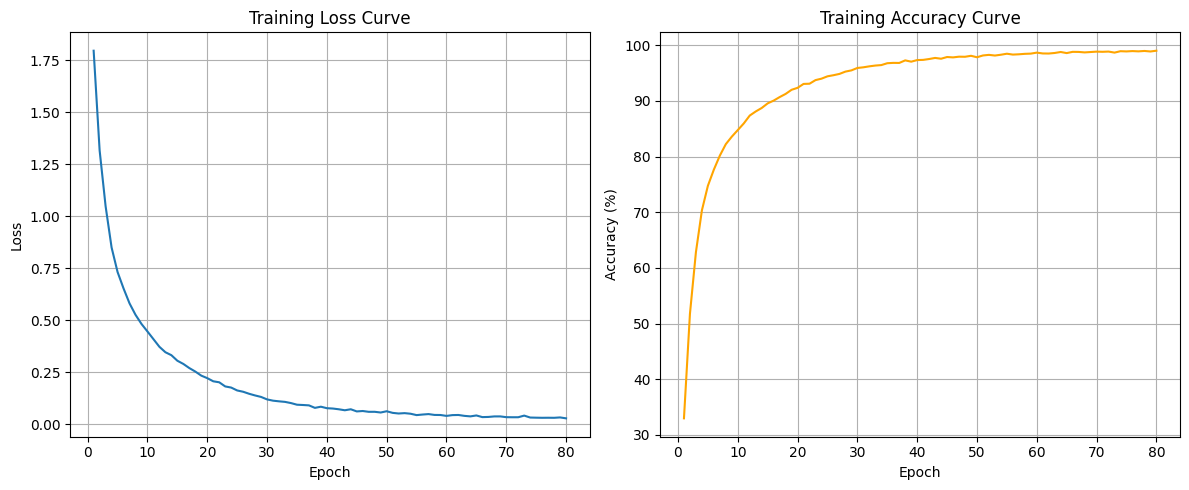

Test Accuracy: 92.43%


In [16]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=80)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [ ]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=120)
plot_training_curves(train_losses, train_accuracies)
test(model)

Epoch 1/120, Loss: 1.7479, Accuracy: 34.43%
Epoch 2/120, Loss: 1.2431, Accuracy: 55.07%
Epoch 3/120, Loss: 0.9856, Accuracy: 65.06%
Epoch 4/120, Loss: 0.8167, Accuracy: 71.40%
Epoch 5/120, Loss: 0.7075, Accuracy: 75.75%
